## W ~ Y xgboost 


In [1]:
import numpy as np
import pandas as pd

import missingno
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import skew,kurtosis
%matplotlib inline

#xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import sort
from sklearn.feature_selection import SelectFromModel

import os
# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'
data2017 = pd.read_csv('NHIS_OPEN_GJ_2017_100.csv',encoding='euc-kr')
data2018 = pd.read_csv('NHIS_OPEN_GJ_2018_100.csv')


In [2]:
data2018['음주여부'] = data2018['음주여부'].fillna(0) #2018 음주여부 nan 값 0으로 채움
data = pd.concat([data2017, data2018]) # 2017, 2018 데이터 합침 
data.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자'],
      dtype='object')

In [3]:
data = data.drop(['기준년도','가입자일련번호','총콜레스테롤','트리글리세라이드','HDL콜레스테롤', 'LDL콜레스테롤','구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자','시도코드', '혈색소', '청력(좌)', '청력(우)','시력(좌)','시력(우)',],1)
data.columns # 컬럼 제거

Index(['성별코드', '연령대코드(5세단위)', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT',
       '감마지티피', '흡연상태', '음주여부'],
      dtype='object')

In [4]:
bmi_ref = data.loc[:,["체중(5Kg단위)", "신장(5Cm단위)"]]
bmi_df = (bmi_ref["체중(5Kg단위)"] / ((bmi_ref["신장(5Cm단위)"]/100)**2))
bmi_df = round(bmi_df)

add_col2 = bmi_df
data['BMI'] = add_col2
data
# missingno.matrix(data,color=(0.1, 0.6, 0.8))

add_col = data['식전혈당(공복혈당)'].copy()

add_col[data['식전혈당(공복혈당)'] < 126] = 0
add_col[data['식전혈당(공복혈당)'] >= 126] = 1

data['당뇨여부'] = add_col

data = data.reset_index(drop=True, inplace=False)

In [5]:
a = data.sort_values(by ='당뇨여부', ascending=False) # 내림차순 정렬, 당뇨여부 1로 잘 들어가잇음
a 

,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg단위),허리둘레,수축기혈압,이완기혈압,식전혈당(공복혈당),요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,BMI,당뇨여부
1519022,1,11,160,70,89.0,133.0,78.0,168.0,1.0,0.8,24.0,25.0,63.0,3.0,1.0,27.0,1.0
433752,2,7,160,75,80.1,130.0,80.0,137.0,1.0,0.7,36.0,42.0,35.0,1.0,1.0,29.0,1.0
1597885,2,11,155,60,82.5,111.0,82.0,126.0,1.0,0.7,19.0,18.0,19.0,1.0,1.0,25.0,1.0
433674,1,9,175,70,81.0,120.0,80.0,139.0,1.0,0.8,24.0,29.0,64.0,3.0,1.0,23.0,1.0
433678,2,16,150,55,79.0,139.0,82.0,132.0,1.0,0.6,25.0,18.0,19.0,1.0,1.0,24.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999074,2,15,140,50,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,26.0,NaN
1999381,2,14,155,50,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,21.0,NaN
1999427,2,14,155,55,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,23.0,NaN
1999439,2,14,165,75,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,28.0,NaN


<AxesSubplot:>

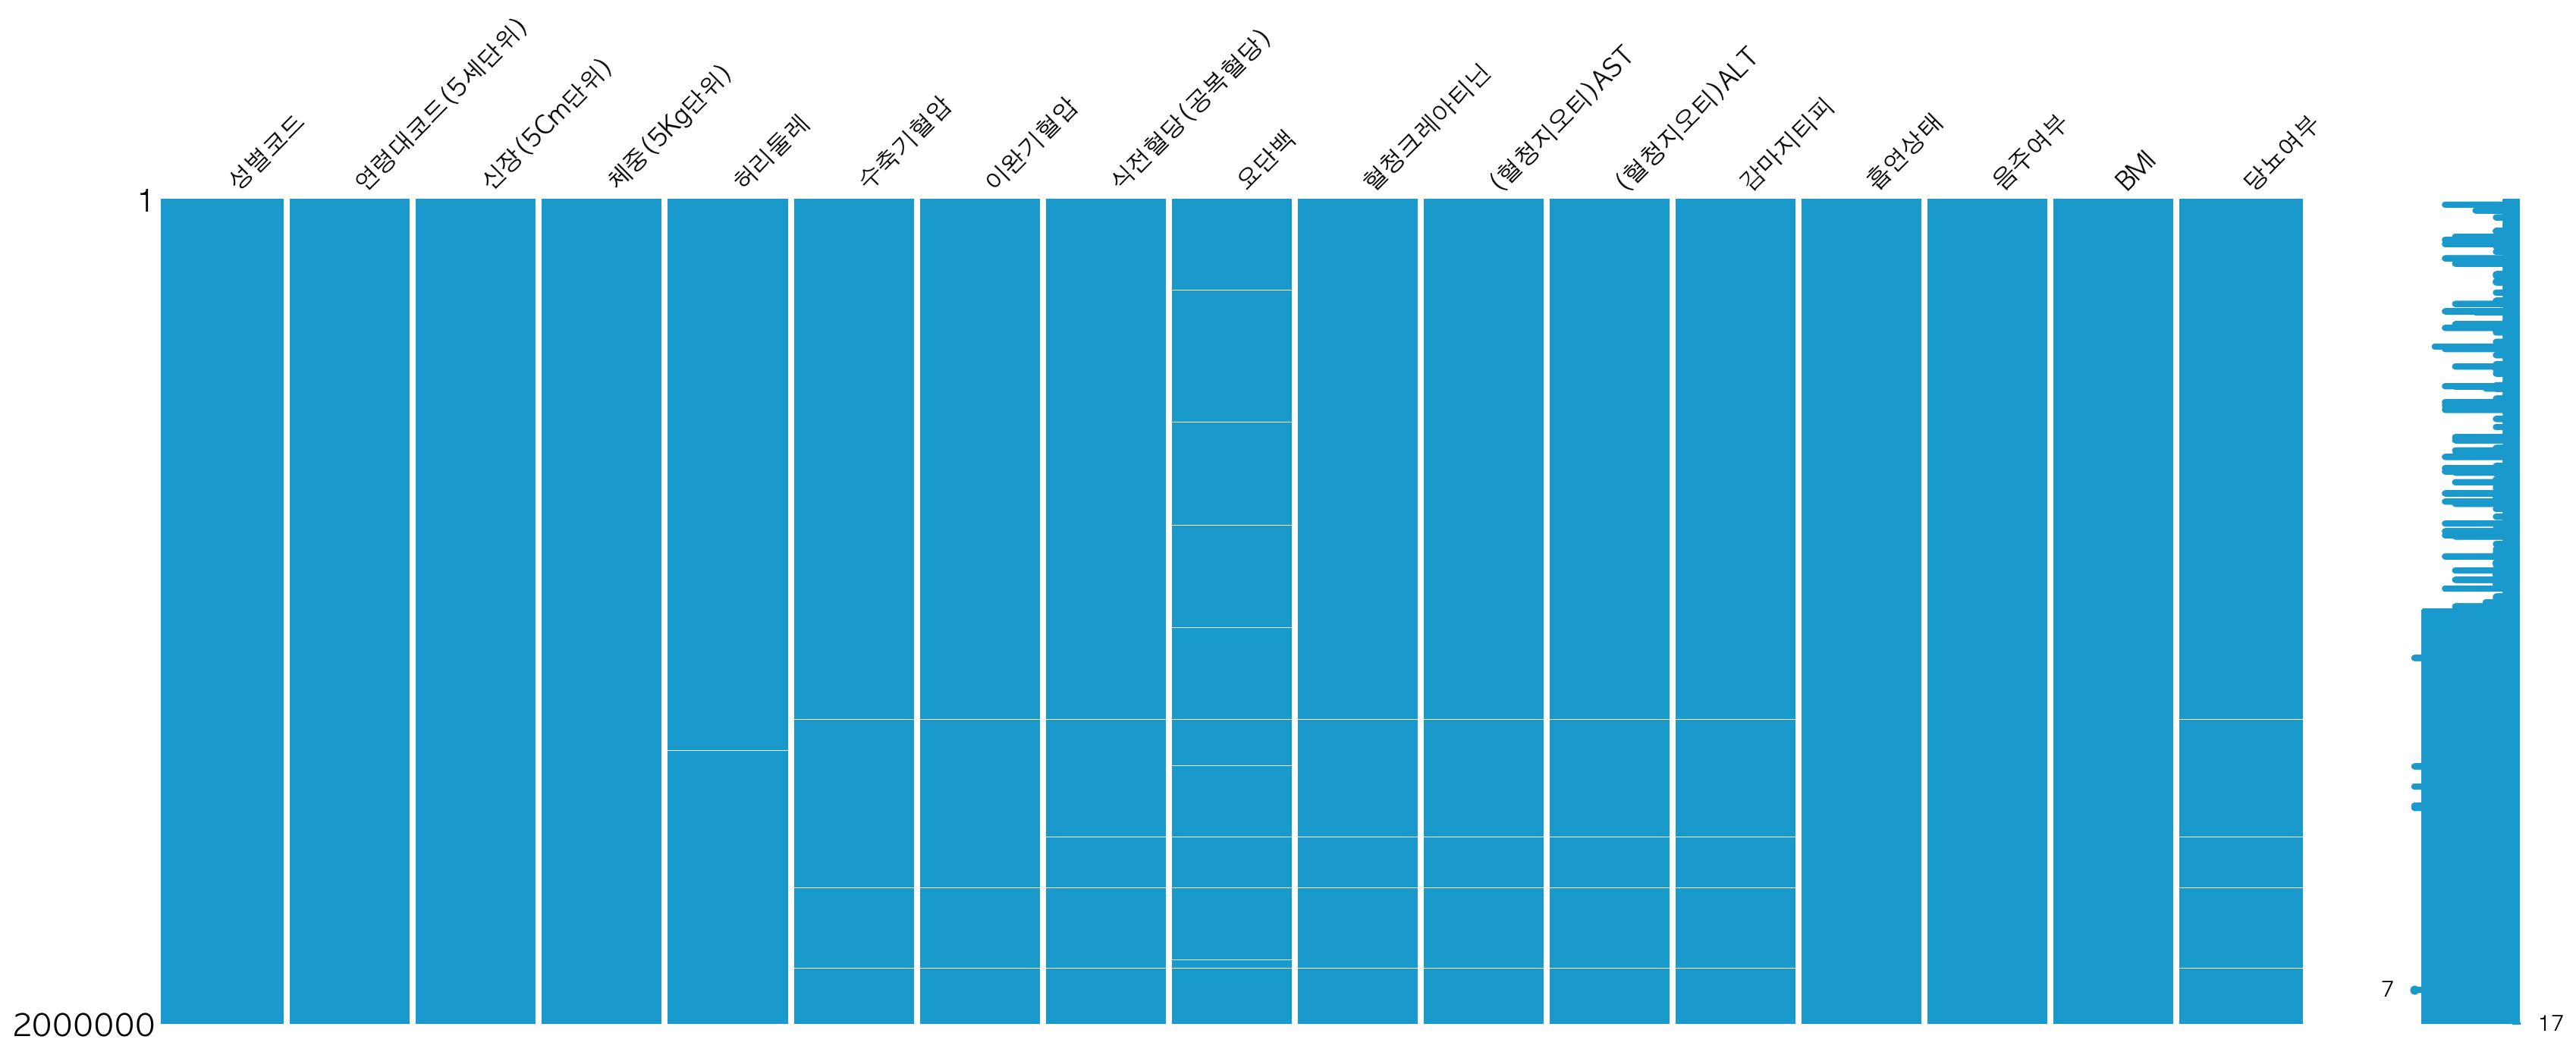

In [6]:
missingno.matrix(data,color=(0.1, 0.6, 0.8))

1983226

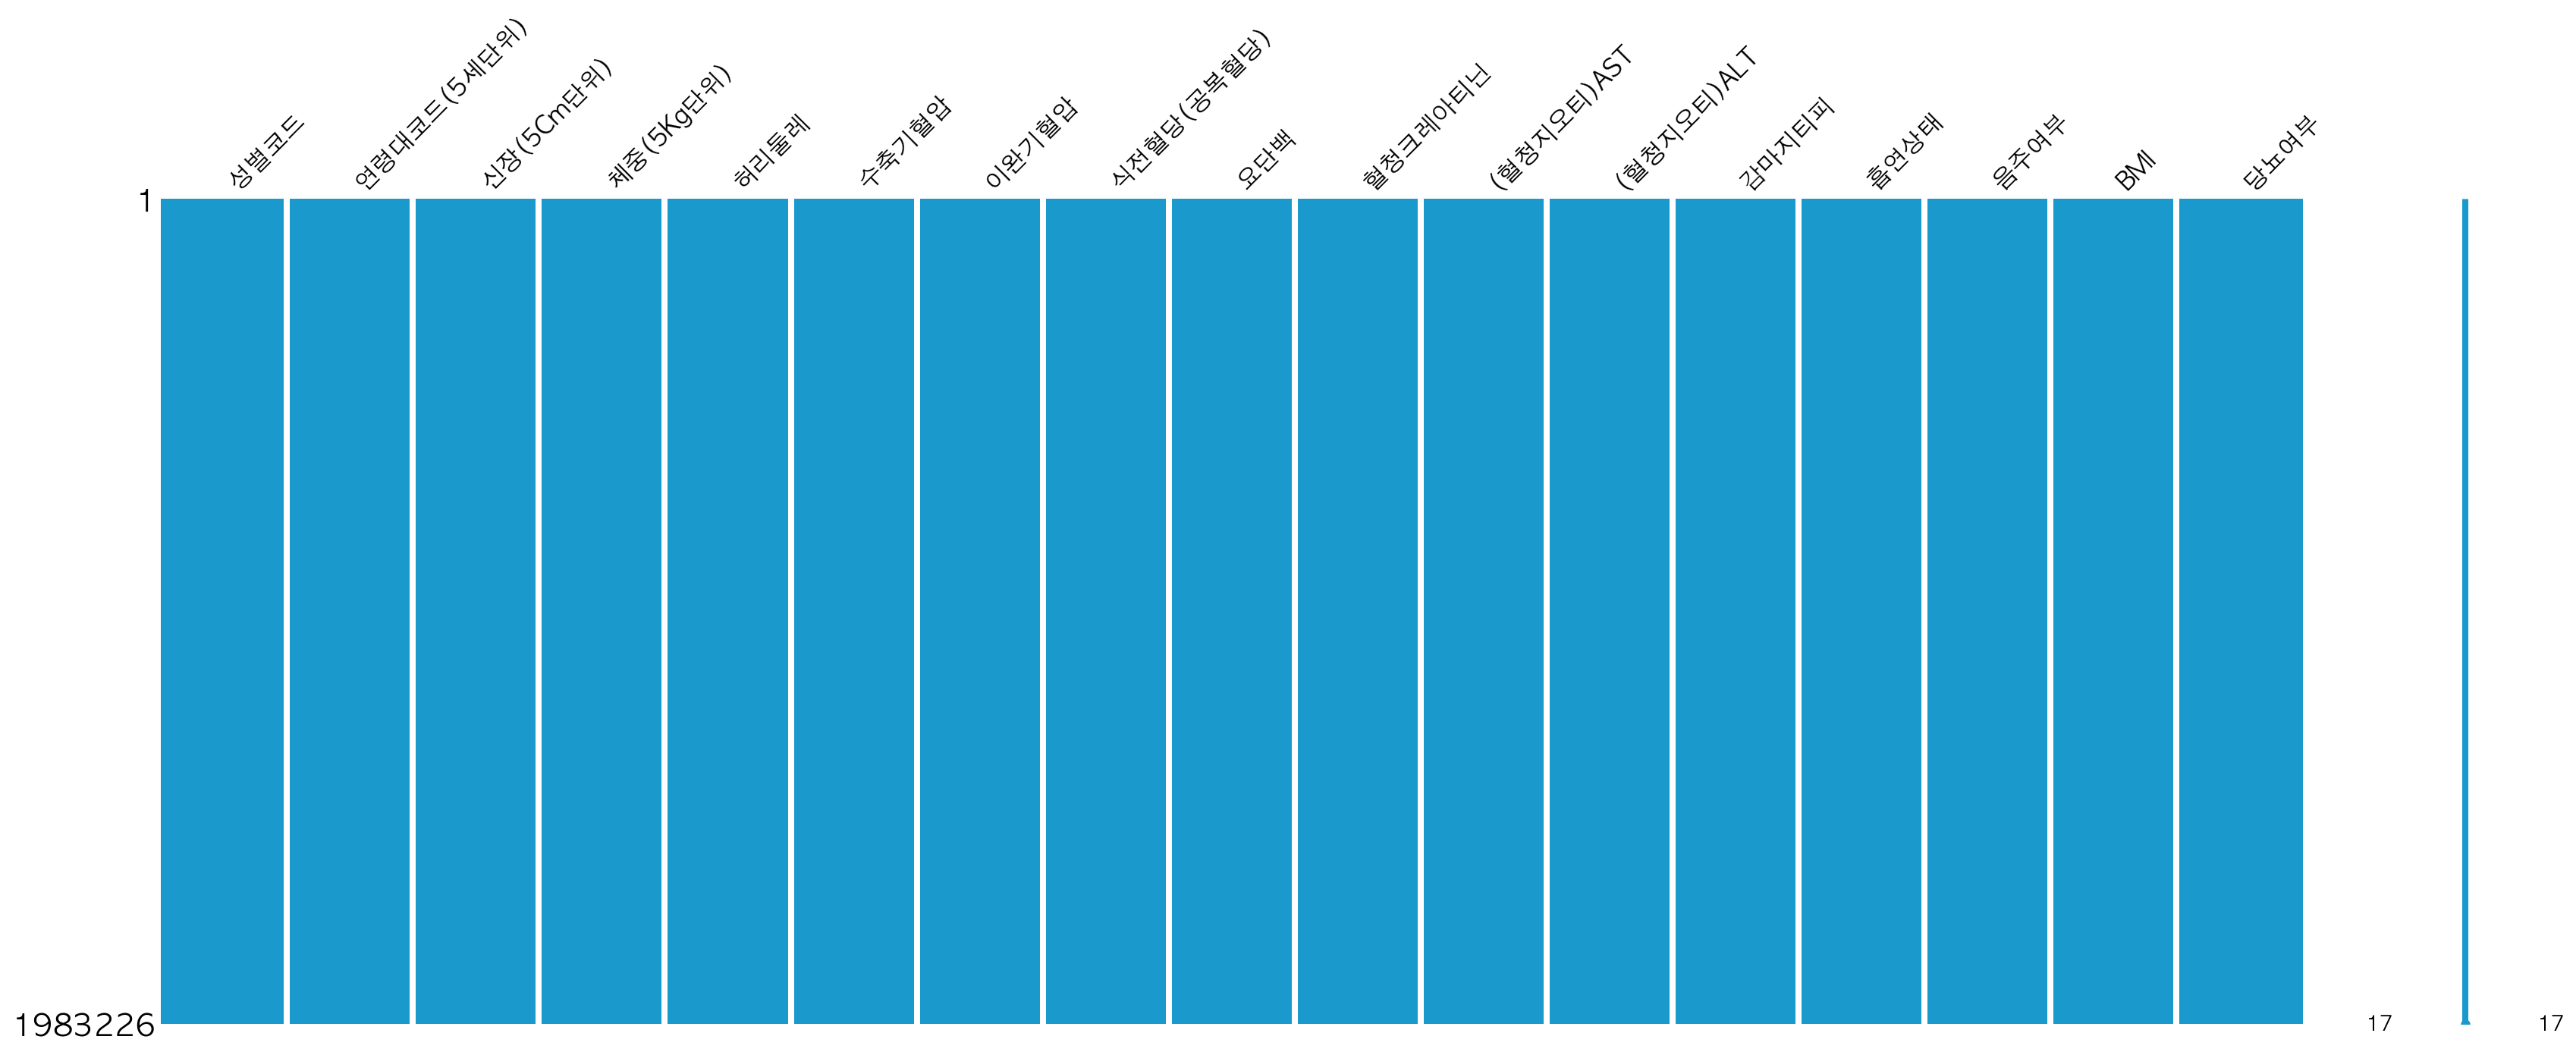

In [7]:
data = data.dropna(axis=0)
missingno.matrix(data,color=(0.1, 0.6, 0.8))
len(data)

## Z-SCORE로 이상치 제거

In [8]:
def z_score_method(df, variable_name):
    columns = df.columns
    z = np.abs(stats.zscore(df))
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable_name:
            index = item
    print("index :",index)
    for i, v in enumerate(z[:, index]):
        if v > threshold:
            outlier.append(i)
        else:
            continue
    return outlier

outlier 인덱스 구하기

In [9]:
bmi = z_score_method(data,'BMI')
waist = z_score_method(data,'허리둘레')
sbp = z_score_method(data,'수축기혈압')
dbp = z_score_method(data,'이완기혈압')
bs = z_score_method(data,'식전혈당(공복혈당)')
bsc = z_score_method(data,'혈청크레아티닌')
ast = z_score_method(data,'(혈청지오티)AST')
alt = z_score_method(data,'(혈청지오티)ALT')
gtp = z_score_method(data,'감마지티피')

index : 15
index : 4
index : 5
index : 6
index : 7
index : 9
index : 10
index : 11
index : 12


In [19]:
union_index = list(set(bmi) | set(waist) | set(sbp)| set(dbp)| set(bs)| set(bsc)| set(ast)| set(alt)| set(gtp))
len(union_index)

116617

In [11]:
drop_outlier = data.drop(data.index[union_index])
drop_outlier = drop_outlier.reset_index(drop=True, inplace=False)
len(drop_outlier)

,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg단위),허리둘레,수축기혈압,이완기혈압,식전혈당(공복혈당),요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,BMI,당뇨여부
0,1,8,170,75,90.0,120.0,80.0,99.0,1.0,1.0,21.0,35.0,40.0,1.0,1.0,26.0,0.0
1,1,7,180,80,89.0,130.0,82.0,106.0,1.0,0.9,20.0,36.0,27.0,3.0,0.0,25.0,0.0
2,1,9,165,75,91.0,120.0,70.0,98.0,1.0,0.9,47.0,32.0,68.0,1.0,0.0,28.0,0.0
3,1,11,175,80,91.0,145.0,87.0,95.0,1.0,1.1,29.0,34.0,18.0,1.0,0.0,26.0,0.0
4,1,11,165,60,80.0,138.0,82.0,101.0,1.0,0.8,19.0,12.0,25.0,1.0,0.0,22.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866604,2,11,165,75,84.0,110.0,70.0,107.0,1.0,0.7,18.0,15.0,19.0,1.0,0.0,28.0,0.0
1866605,1,7,170,75,88.0,136.0,88.0,114.0,1.0,1.0,25.0,36.0,90.0,1.0,1.0,26.0,0.0
1866606,1,8,175,80,87.0,162.0,90.0,98.0,1.0,0.9,21.0,15.0,36.0,2.0,1.0,26.0,0.0
1866607,1,11,165,70,80.2,140.0,98.0,94.0,1.0,1.2,20.0,18.0,14.0,2.0,0.0,26.0,0.0


1866609 개 ..??

## XGBOOST

In [12]:
diabetesData = drop_outlier
print(diabetesData['당뇨여부'].value_counts())
# print(type(diabetesData))

# 당뇨 O : 107166
# 당뇨 X : 1759443

0.0    1759443
1.0     107166
Name: 당뇨여부, dtype: int64


In [13]:
x = diabetesData.drop(['당뇨여부','식전혈당(공복혈당)'], axis=1)
x = x.to_numpy()
x

array([[  1.,   8., 170., ...,   1.,   1.,  26.],
       [  1.,   7., 180., ...,   3.,   0.,  25.],
       [  1.,   9., 165., ...,   1.,   0.,  28.],
       ...,
       [  1.,   8., 175., ...,   2.,   1.,  26.],
       [  1.,  11., 165., ...,   2.,   0.,  26.],
       [  1.,   5., 165., ...,   1.,   1.,  22.]])

In [14]:
y = diabetesData['당뇨여부']
y = y.to_numpy()
y

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
# 데이터셋 변경 방지
seed = 7

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
#(머신러닝 모델에 train 데이터를 100% 학습시킨 후 test 데이터에 모델을 적용했을 때 성능이 생각보다 않 나오는 경우가 많다)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

In [16]:
model = XGBClassifier()
model.fit(X_train, y_train)

[14:00:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 94.25%


예측 정확도 94.25% 

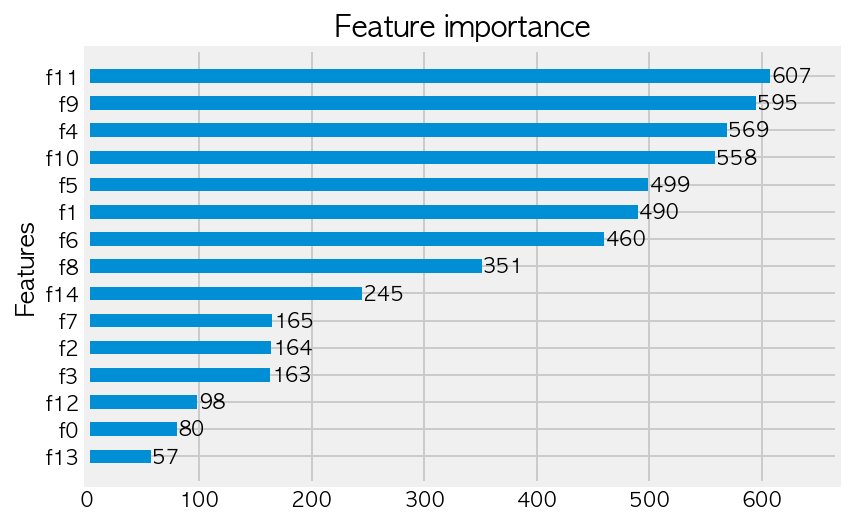

In [18]:
plot_importance(model, height=0.5, xlabel='', ylabel='Features')
plt.show()


# feature_names = ['성별코드','연령대코드','신장','체중','허리둘레','수축기혈압','이완기혈압','요단백','혈청크레아티닌','(혈청지오티)AST','(혈청지오티)ALT','감마지티피', '흡연상태','음주여부', 'BMI']
# sorted_idx = model.feature_importances_.argsort()
# plt.barh(feature_names[sorted_idx][:10], model.feature_importances_[sorted_idx][:10])

f0 - 성별코드<br>
f1 - 연령대코드<br> 
f2 - 신장 <br>
f3 - 체중<br>
f4 - 허리둘레<br>
f5 - 수축기혈압<br>
f6 - 이완기혈압<br>
f7 - 요단백<br>
f8 - 혈청크레아티닌<br>
f9 - (혈청지오티)AST	<br>
f10 - (혈청지오티)ALT	
f11 - 감마지티피<br>
f12 - 흡연상태<br>
f13 - 음주여부<br>
f14 - BMI<br>

1. 감마지티피
2. (혈청지오티)AST	
3. 허리둘레
4. (혈청지오티)ALT	
5. 수축기혈압
순위로 중요도가 높게 나왔다!